### Step 1: Install Graphviz
#### On Windows
- Download and install Graphviz from here`(https://graphviz.org/download/)`.
- During installation, check the box to "Add Graphviz to the system PATH."
- Restart your terminal or Jupyter Notebook.
- Verify the installation by running:
```sh
dot -V
```
If it prints something like dot - graphviz version X.Y.Z, Graphviz is installed.
#### On macOS (Homebrew)
```sh
brew install graphviz
```
#### On Linux (Ubuntu/Debian)
```sh
sudo apt update
sudo apt install graphviz
```

In [58]:
try:
    import numpy as np
except ImportError:
    %pip install numpy
    import numpy as np

try:
    import pandas as pd
except ImportError:
    %pip install pandas
    import pandas as pd

try:
    import seaborn as sns
except ImportError:
    %pip install seaborn
    import seaborn as sns

try:
    import matplotlib.pyplot as plt
except ImportError:
    %pip install matplotlib
    import matplotlib.pyplot as plt

try:
    from sklearn import datasets, model_selection, metrics
except ImportError:
    %pip install scikit-learn
    from sklearn import datasets, model_selection, metrics

%pip install graphviz

from subprocess import check_call
import re


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
# Load NeuralNetwork class

import importlib
import tree_node
import decision_tree
import random_forest
import ada_boost

importlib.reload(tree_node)
importlib.reload(decision_tree)
from decision_tree import DecisionTree
importlib.reload(random_forest)
from random_forest import RandomForestClassifier
importlib.reload(ada_boost)
from ada_boost import AdaBoostClassifier

In [60]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

original_train = train.copy()
original_test = test.copy()

full_data = [train, test]

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [61]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [62]:
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)


# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+).', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3

In [63]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1.0
1,1,1,0,2,0,3,1,1,2,0,3.0
2,1,3,0,1,0,1,0,0,1,1,4.0


<Axes: title={'center': 'Pearson Correlation of Features'}>

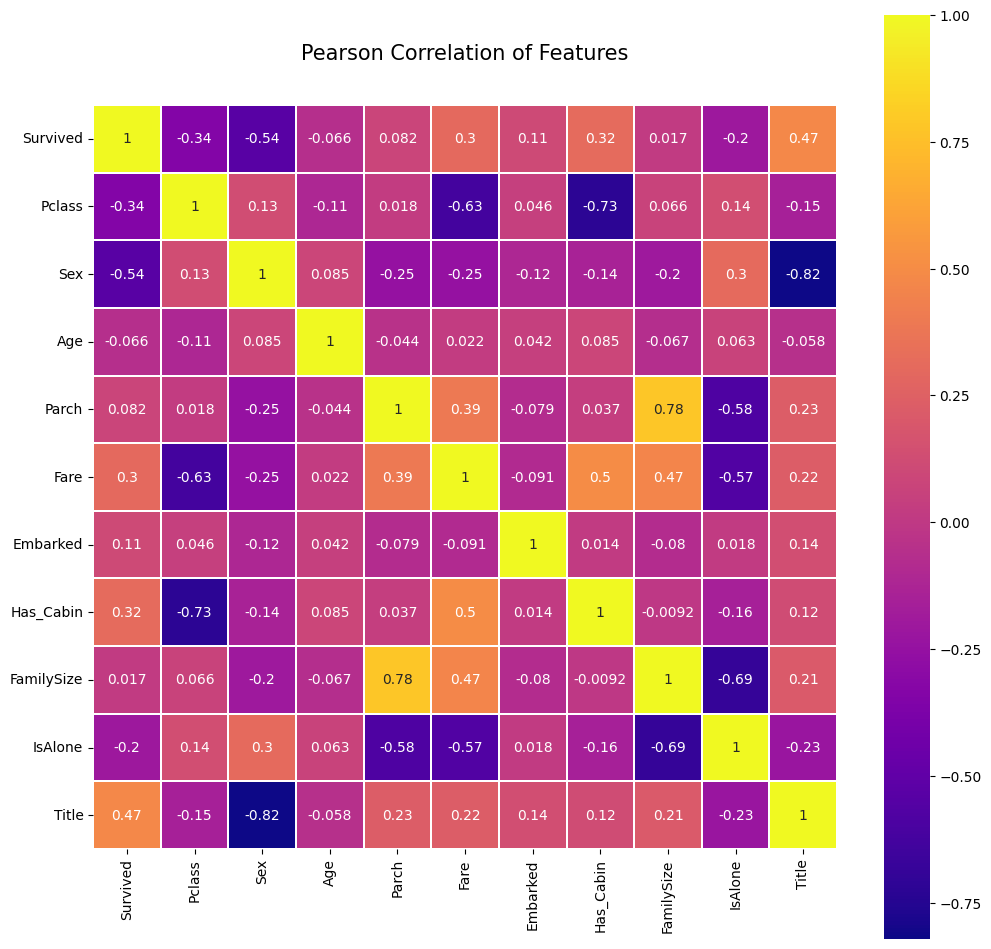

In [64]:
colormap = plt.colormaps['plasma']
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [65]:
x = train.copy()
x.drop("Survived", axis=1, inplace=True)
y = train["Survived"]

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, random_state=0)

In [66]:
decision_tree = DecisionTree(max_depth=4, min_samples_leaf=1, min_samples_split=0, feature_names=x.columns.values)
decision_tree.fit(x_train, y_train)

predicted_classes = decision_tree.predict(x_test)

accuracy = metrics.accuracy_score(y_test, predicted_classes)
print(accuracy)

0.8251121076233184


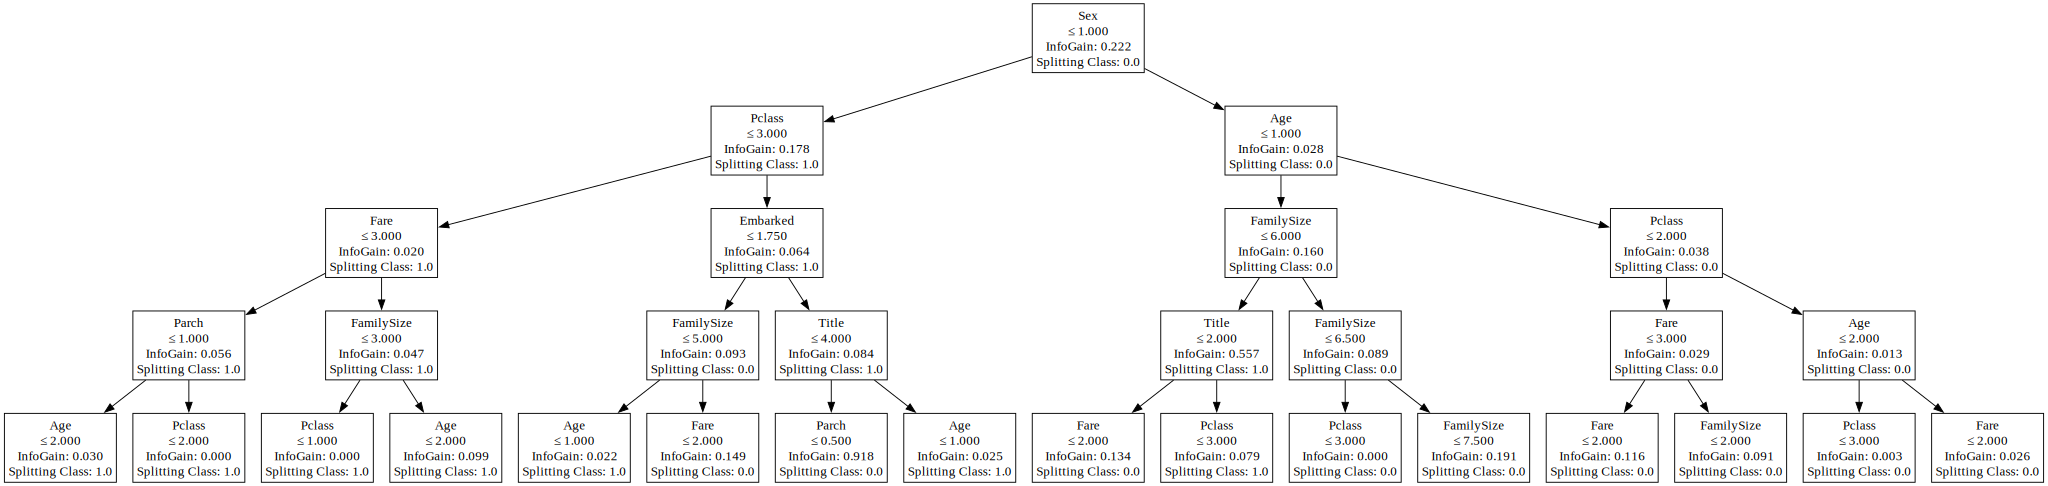

In [67]:
decision_tree.visualize_tree()